<a href="https://colab.research.google.com/github/rboghe/YACD-YetAnotherCovid19Detector/blob/master/Covid_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Disclaimer: this notebook is intended for educational purposes only. Do **NOT** attempt to use it as a diagnostic tool.

Severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2) has caused a large global outbreak and is a major public health issue. In this notebook we will explore the feasibility of using AI-based solutions to detect the presence of the virus in patients through chest x-rays. The images are taken from [[1]](https://github.com/ieee8023/covid-chestxray-dataset) and [[2]](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia/) and stored on my [GitHub](https://github.com/rboghe/Covid-19). For a faster execution enable GPU usage (if you're using Colab, just click on Runtime -> Change Runtime Type and select GPU under Hardware Accelerator).

First, let's import the necessary libraries:

In [1]:
%tensorflow_version 2.x

import os
import io
import requests
import shutil
import zipfile
import random
import math
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import matplotlib.pyplot as plt

TensorFlow 2.x selected.


Clearing the tensorflow session erases all the nodes left from previous models that could impact our training:

In [0]:
tf.keras.backend.clear_session()

The images are stored in two zip files on my GitHub. The following code retrieves and extracts the files:

In [0]:
try:
  shutil.rmtree('/tmp')
except:
  pass

path_covid = 'https://github.com/rboghe/CovidLambda/blob/master/covid.zip?raw=true'
path_notcovid = 'https://github.com/rboghe/CovidLambda/blob/master/not_covid.zip?raw=true'

# Get positive xrays
req = requests.get(path_covid)
zip_ref = zipfile.ZipFile(io.BytesIO(req.content))
zip_ref.extractall('/tmp')
zip_ref.close()

# Get negative xrays
req_not = requests.get(path_notcovid)
zip_ref_not = zipfile.ZipFile(io.BytesIO(req_not.content))
zip_ref_not.extractall('/tmp')
zip_ref_not.close()

Let's check if the images have been correctly stored:

In [4]:
# Check if everything went well
print('Positive samples are', len(os.listdir('/tmp/covid/'))) # Should be 72
print('Negative samples are',len(os.listdir('/tmp/not_covid/'))) # Should be 88

Positive samples are 72
Negative samples are 88


The images have different dimensions, aspect ratios and color spaces, but the neural network will need equally shaped inputs. We can load them in grayscale:

In [0]:
covid = []
not_covid = []

for filename in os.listdir('/tmp/covid/'):
    img_path = os.path.join('/tmp/covid/', filename)
    image = tf.keras.preprocessing.image.load_img(img_path, color_mode="grayscale")
    covid.append(image)
  
for filename in os.listdir('/tmp/not_covid/'):
    img_path = os.path.join('/tmp/not_covid/', filename)
    image = tf.keras.preprocessing.image.load_img(img_path, color_mode="grayscale")
    not_covid.append(image)

Let's plot a random image to see how it looks before the next step:

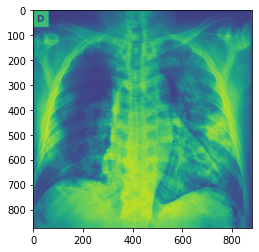

In [6]:
random_n = random.randint(1,len(covid)-1) 
image = covid[random_n]
plt.imshow(image)
plt.show()

The next block will resize all the images to fixed width and height while keeping their original aspect ratio:

In [0]:
# Resize images
def reshape_image(image, new_size=(150,150)):
    background = Image.new('L', new_size, "black")
    image.thumbnail(new_size)
    (w, h) = image.size
    background.paste(image, ((new_size[0] - w) // 2, (new_size[1] - h) // 2 ))
    return background

height = 300
width = 300

target_size = (height, width)

covid = [reshape_image(x, new_size=(height, width)) for x in covid]
not_covid = [reshape_image(x, new_size=(height, width)) for x in not_covid]

Let's see how the previous image was transformed:

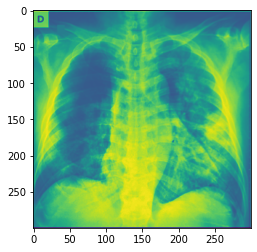

In [8]:
image = covid[random_n]
plt.imshow(image)
plt.show()

Now that all the images have been preprocessed, it's time to randomly split the data: we'll create a training and a validation set, while keeping some images for testing the model.

In [9]:
def split_data(source_0, source_1, split_size=[.8, .1]):
    if split_size[0] + split_size[1] > 1:
      print('Please, check your split size')
      raise SystemExit
    X_train = []
    y_train = []
    X_val = []
    y_val = []
    random.shuffle(source_0)
    test_split_0 = int(len(source_0)*split_size[0])
    val_split_0 = int(len(source_0)*split_size[1])
    for _ in range(test_split_0):
      X_train.append(source_0.pop(0))
      y_train.append(0)
    for _ in range(val_split_0):
      X_val.append(source_0.pop(0))
      y_val.append(0)
    random.shuffle(source_1)
    test_split_1 = int(len(source_1)*split_size[0])
    val_split_1 = int(len(source_1)*split_size[1])
    for _ in range(test_split_1):
      X_train.append(source_1.pop(0))
      y_train.append(1)
    for _ in range(val_split_1):
      X_val.append(source_1.pop(0))
      y_val.append(1)
    return X_train, y_train, X_val, y_val

X_train, y_train, X_val, y_val = split_data(not_covid, covid, split_size=[.806,.111])
    

print('There are {} samples in X_train'.format(len(X_train))) # Should be 128
print('There are {} labels in y_train'.format(len(y_train))) # Should be 128
print('There are {} samples in X_val'.format(len(X_val))) # Should be 16
print('There are {} labels in y_val'.format(len(y_val))) # Should be 16
print('There are {} positive samples left for testing'.format(len(covid))) # Should be 7
print('There are {} negative samples left for testing'.format(len(not_covid))) # Should be 9

There are 128 samples in X_train
There are 128 labels in y_train
There are 16 samples in X_val
There are 16 labels in y_val
There are 7 positive samples left for testing
There are 9 negative samples left for testing


In [0]:
# Shuffle train samples
c = list(zip(X_train, y_train))
random.shuffle(c)
X_train, y_train = zip(*c)
# Shuffle val samples
c = list(zip(X_val, y_val))
random.shuffle(c)
X_val, y_val = zip(*c)

In [0]:
# Convert images into numpy arrays
X_train = [tf.keras.preprocessing.image.img_to_array(x) for x in X_train]
X_val = [tf.keras.preprocessing.image.img_to_array(x) for x in X_val]
X_train = np.asarray(X_train)
X_val = np.asarray(X_val)

It's time to build the model. We'll use ImageDataGenerator to augment the training data:

In [0]:
# Prepare train data
batch_size = 32
val_batch_size = 4

train_datagen = ImageDataGenerator(rescale = 1/255,rotation_range=10, width_shift_range=0.1,
    height_shift_range=0.1,  shear_range=0.1, zoom_range=0.0, fill_mode='nearest')

train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)

# Prepare val data
val_datagen = ImageDataGenerator(rescale = 1/255)
val_generator = val_datagen.flow(X_val, y_val, batch_size = val_batch_size)

# Build model
model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64, (3,3), input_shape=(width,height,1), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(64,(3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(64,(3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(64,(3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(64,(3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(64,(3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(256),
        tf.keras.layers.Dense(1, activation='sigmoid')])

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 298, 298, 64)      640       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 149, 149, 64)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 147, 147, 64)      36928     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 71, 71, 64)        36928     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 33, 33, 64)       

In [16]:
model.compile(optimizer = tf.keras.optimizers.Adam(), 
              loss='binary_crossentropy', 
              metrics=['acc'])

history = model.fit(train_generator,
                    epochs = 80,
                    steps_per_epoch=len(X_train)/batch_size,
                    validation_data=val_generator,
                    validation_steps=len(X_val)/val_batch_size)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 4.0 steps, validate for 4.0 steps
Epoch 1/80
4/4 [==============================] - 3s 839ms/step - loss: 0.6851 - acc: 0.5234 - val_loss: 0.6740 - val_acc: 0.5625
Epoch 2/80
4/4 [==============================] - 1s 225ms/step - loss: 0.6749 - acc: 0.5469 - val_loss: 0.6331 - val_acc: 0.5625
Epoch 3/80
4/4 [==============================] - 1s 222ms/step - loss: 0.6261 - acc: 0.6094 - val_loss: 0.4762 - val_acc: 0.8125
Epoch 4/80
4/4 [==============================] - 1s 228ms/step - loss: 0.5265 - acc: 0.7344 - val_loss: 0.6640 - val_acc: 0.6875
Epoch 5/80
4/4 [==============================] - 1s 225ms/step - loss: 0.5795 - acc: 0.7266 - val_loss: 0.3715 - val_acc: 0.8125
Epoch 6/80
4/4 [==============================] - 1s 227ms/step - loss: 0.4886 - acc: 0.7891 - val_loss: 0.4354 - val_acc: 0.8125
Epoch 7/80
4/4 [==============================] - 1s 227ms/step - loss: 0.4819 - acc: 0.7734 - val_loss: 0.3056 - val_acc: 0.8

We can plot the accuracy and loss against the epochs to see how the model evolved:

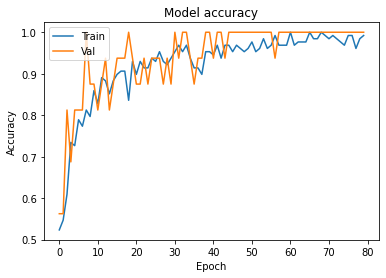

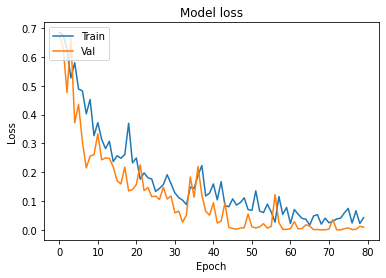

In [17]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

Finally, we can test the newly created model on the test data. The positive samples should be labeled as 1, while the negative samples should be labeled as 0. Let's try:

In [18]:
covid = [tf.keras.preprocessing.image.img_to_array(x) for x in covid]
not_covid = [tf.keras.preprocessing.image.img_to_array(x) for x in not_covid]
covid = np.asarray(covid)
not_covid = np.asarray(not_covid)

covid_test = model.predict(covid)
print(covid_test)

not_covid_test = model.predict(not_covid)
print(not_covid_test)


[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


If everything went as expected, you should see a list of 1s and a list of 0s. If not, well, no model is perfect. Feel free to experiment with different parameters, NN architectures and image augmetations, and if you see an improvement over my model, I'll be more than happy to know how you did!